#  Simple population model nondimensionalized
*This Jupyter notebook presents the __Lotka-Volterra model__  between two species.*
Based on exercises 6.4.4 and 6.5.19 of Strogatz's *Nonlinear Dynamics and Chaos*, there is the nondimensionalized form of the simple Lorka-Volterra model.

In [1]:
# Numerical package
import numpy as np

#Differential equation numerical solver
from scipy.integrate import odeint

# Import pyplot for plotting
import matplotlib.pyplot as plt

# To compute symbolic expressions
import sympy
# print outputs in LaTeX
sympy.init_printing(use_unicode=True) 

# Interactive manipulations in the notebook
#from ipywidgets import interact

# Magic function to make matplotlib inline
%matplotlib inline

# This enables SVG graphics inline.
%config InlineBackend.figure_formats = {'png', 'retina'}

# Suppress future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Lotka-Volterra equations

Here, by starting from what has been described in the Jupyter notebook on the [Simple Volterra model](Simple_Model.ipynb), we nondimensionalize and bring the parameter from four $r_1,r_2,b_1,b_2$ to one $\rho$, i.e.

\begin{align}
    \frac{dx}{dt} &= x \left(1-y \right),\\[1em]
    \frac{dy}{dt} &= y \left( \rho - x \right),
\end{align}

where
- $x,y$ = population size
- $t$ = time
- $\rho = \frac{r_2}{r_1}$

## Using SymPy for Lotka-Volterra

We define the variables that we will use for our symbolic calculations.

In [2]:
# We split it into two definitions to remind us that
# a set of variables is for species 1 and the other one for species 2
# Species 1
r1, b1 = sympy.symbols('r_1 b_1')
# Species 2
r2, b2 = sympy.symbols('r_2 b_2')

#function for species 1 and 2
N1, N2 = sympy.symbols('N_1 N_2', cls=sympy.Function) 

#temporal value
tau = sympy.symbols('tau')

We can now define the differential equations in sympy

In [3]:
diffeq1 = sympy.Eq(N1(tau).diff(tau),  r1 * N1(tau) + b1 * N1(tau)*N2(tau))
diffeq2 = sympy.Eq(N2(tau).diff(tau),  r2 * N2(tau) + b2 * N1(tau)*N2(tau))

And in the `IPython notebook` we can nicely display it as $\LaTeX$.

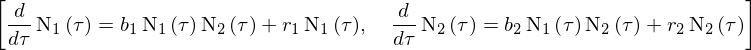

In [4]:
[diffeq1, diffeq2]

### Nondimensionalization

In [5]:
# a set of variables for nondimensionalization

N10, N20= sympy.symbols('N_10 N_20')
rho = sympy.symbols('rho')
x, y = sympy.symbols('x y', cls=sympy.Function) 
t, T = sympy.symbols('t T')

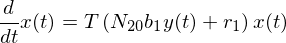

In [6]:
# substitution
listSubs1=[(N1(tau).diff(tau), x(t).diff(t)/T*N10), (N1(tau), x(t)*N10), (N2(tau), y(t)*N20)]
NdDiffeq1=diffeq1.subs(listSubs1)
mult=T/N10
NdDiffeq1=sympy.simplify(sympy.Eq(sympy.Mul(NdDiffeq1.lhs,mult), sympy.Mul(NdDiffeq1.rhs,mult)))
NdDiffeq1

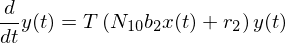

In [7]:
listSubs2=[(N2(tau).diff(tau), y(t).diff(t)/T*N20), (N2(tau), y(t)*N20), (N1(tau), x(t)*N10)]
NdDiffeq2=diffeq2.subs(listSubs2)
mult=T/N20
NdDiffeq2=sympy.simplify(sympy.Eq(sympy.Mul(NdDiffeq2.lhs,mult), sympy.Mul(NdDiffeq2.rhs,mult)))
NdDiffeq2

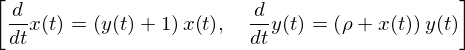

In [8]:
# fix parameters for nondimensionalization
listSubs=[(T, 1/r1), (N20, r1/b1), (N10, r1/b2), (r2, rho*r1)]
NdDiffeq1=sympy.simplify(NdDiffeq1.subs(listSubs))
NdDiffeq2=sympy.simplify(NdDiffeq2.subs(listSubs))

[NdDiffeq1,NdDiffeq2]


### Stationary states
Now we find the steady state, i.e. find when the derivative with respect to time equals to zero.

In [9]:
# set new time-independent variables
x, y = sympy.symbols('x y') 
listSubsVarib=[(x(t),x), (y(t),y) ]

NdDiffeq1.rhs.subs(listSubsVarib),NdDiffeq2.rhs.subs(listSubsVarib)

In [10]:
ss_x = sympy.Eq(NdDiffeq1.rhs.subs(listSubsVarib), 0)
ss_y = sympy.Eq(NdDiffeq2.rhs.subs(listSubsVarib), 0)
ss_x, ss_y

In [11]:
print('The steady state solution for both species are:')
ss_dict_xy = sympy.solve((ss_x, ss_y),(x, y))
ss_dict_xy

The steady state solution for both species are:


So we find that there is on steady state solution: the trivial solution in which both species are extinct, so $x = y = 0$ and the solution $(-\rho, -1)$

### Jacobian

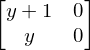

In [12]:
M=sympy.Matrix([ss_x.lhs, ss_y.lhs])
Jvar = sympy.Matrix([x, t])
J=M.jacobian(Jvar)
J

In [13]:
 #Here we create a numerical version of the Jacobian matrix
d2N_dt2_num = sympy.utilities.lambdify([x, y, rho], J, ("math", "mpmath", "sympy"))

In [14]:
EigenVal = []
for ssSol in ss_dict_xy:
    replacements = []
    replacements = [(X, ssSol[i]) for i, X in enumerate([x, y])]
    EigenVal.append(J.subs(replacements).eigenvals()) #eigenvals  eigenvects
print('The Eigenvalues:')
EigenVal

The Eigenvalues:


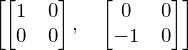

In [15]:
StStateMatrix = []
for ssSol in ss_dict_xy:
    replacements = []
    replacements = [(X, ssSol[i]) for i, X in enumerate([x, y])]
    StStateMatrix.append(J.subs(replacements)) #eigenvals
StStateMatrix

### Numerical simulation

We can use `scipy`'s numerical solver to run a simulation for this system of equations.

In order to avoid rewriting the function we'll use `lambdify`.  `lambdify` takes a `sympy` symbolic expression and returns a function that can be either numerically or symbolically evaluated with other values.  This would allow us to evaluate and plot any function that comes out of `sympy`'s toolkit.

In [16]:
#ss_y_param=ss_y.lhs.subs('rho',2)
#ss_y_param
ss_x, ss_y

In [17]:
# Generate 'lambdify' functions to numerically evaluate the diff. equations
dX_dt_numeric = sympy.utilities.lambdify([x, y, 'rho'], [ss_x.lhs,ss_y.lhs], ("math", "mpmath", "sympy"))

In [18]:
def lotka_voltera_rhs(X, t, *p):
    '''
    Set up the right hand side (rhs) function for the system 
    (necessary step to feed sympy's odeint function).
    '''
    rho = p
    evald_dt=dX_dt_numeric(X[0],X[1], rho)
    
    
    return np.array([evald_dt[0], 
                    evald_dt[1]])

### Example 1
Competition case.

In [19]:
# Initial population size
x_y_0 = np.array([-2, 10]) 

#rate of replacement
rho=3

argsPar = (rho,)
# Time points we want to consider
t = np.linspace(0, 2, 1000)

# Now let's use odeint to solve the function
sol_xy, infodict = odeint(lotka_voltera_rhs, x_y_0, t, args=argsPar, full_output = True)
infodict['message']                     # >>> 'Integration successful.'

'Integration successful.'

In [20]:
ReplParamVal=[('rho',argsPar[0])]
ss_dict_xy

In [21]:
EqPoint=[[elem[0].subs(ReplParamVal),elem[1].subs(ReplParamVal)] for elem in ss_dict_xy]
EqPoint

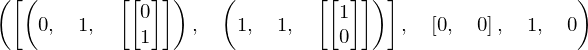

In [22]:
Eigen=[]
Trace=[]
Deter=[]
for Matrix in StStateMatrix:
    Eigen.append(Matrix.subs(ReplParamVal).eigenvects())
    Trace.append(Matrix.subs(ReplParamVal).trace())
    Deter.append(Matrix.subs(ReplParamVal).det())

Eigen[0], EqPoint[0], Trace[0], Deter[0]

Looking at the eigenvectors of the point $(0,0)$ we can see that they are both real, one is zero and the other is positive, $1$. Positive trace and zero determinant: it is an unstable fixed points.

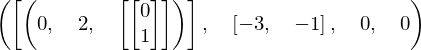

In [23]:
Eigen[1], EqPoint[1], Trace[1], Deter[1]

Looking at the eigenvectors of the point $(-\rho,-1)$ we can see that they are both zero. Zero trace and zero determinant: it is a line of fixed points.

We will now plot the solution.

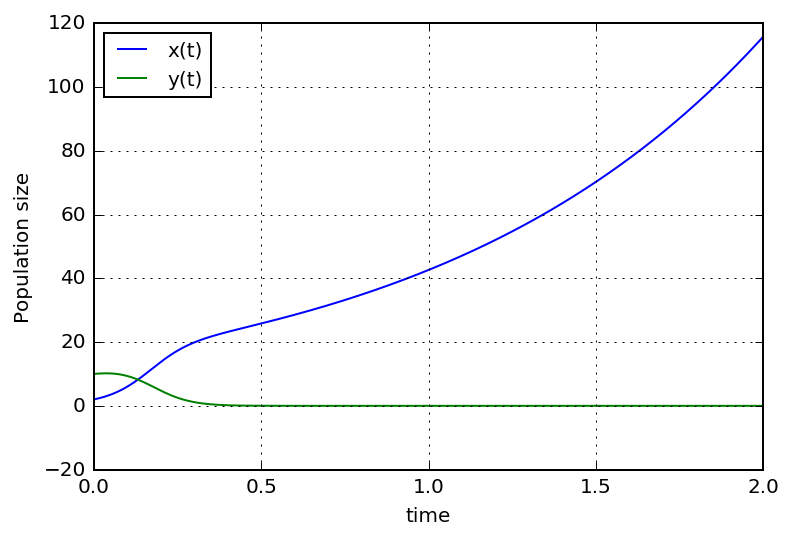

In [24]:
f1 = plt.figure()
plt.plot(t, -sol_xy[:, 0], 'b', label='x(t)')
plt.plot(t, sol_xy[:, 1], 'g', label='y(t)')
plt.legend(loc='best', fontsize=10)
plt.xlabel('time')
plt.ylabel('Population size')
plt.grid()
plt.show()
f1.savefig('OutImage/rabbits_and_sheep_NonDim_1.png')

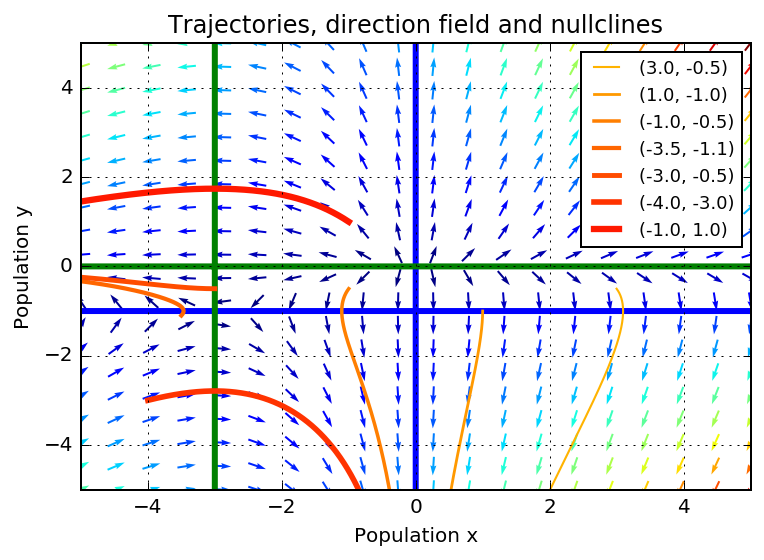

In [25]:
X_f1= np.array(EqPoint[1][:], dtype=np.float64)
X_fs= np.array(x_y_0 , dtype=np.float64) #x_y_0 EqPoint[1][:]

#StartPoints = np.array([[X_f1[0]-2,X_f1[1]+1], [X_fs[0]-1,X_fs[1]+1], [2,-1] , [-1,-5], [1,-2], [1,3]])  
StartPoints = np.array([[3,-0.5],[1,-1], [-1,-0.5],[-3.5,-1.1], [-3,-0.5], [-4,-3], [-1,1],  ])  #TODO Look after: [2,3]
values  = np.linspace(0.3, 0.9, len(StartPoints))   

t = np.linspace(0, 2, 3000)
f2 = plt.figure()
# plot trajectories
for point, v in zip(StartPoints, values): 
    X0 = point                     # starting point (internal)
    sol_X = odeint(lotka_voltera_rhs, np.transpose(X0), t, args=argsPar)
    plt.plot( sol_X[:,0], sol_X[:,1], lw=3.5*v, color=plt.cm.autumn_r(v), label='(%.1f, %.1f)' % ( X0[0], X0[1]) )

#-------------------------------------------------------
# define a grid and compute direction at each point
ymax = 5 #plt.ylim(ymin=0)[1]                      # get axis limits
xmax = 5 #plt.xlim(xmin=0)[1] 
ymin = -5
xmin = -5
nb_points   = 20                      

x = np.linspace(xmin, xmax, nb_points)
y = np.linspace(ymin, ymax, nb_points)

X1 , Y1  = np.meshgrid(x, y)                       # create a grid
DX1, DY1 = dX_dt_numeric(X1, Y1, argsPar[0])   # compute growth rate on the grid
M = (np.hypot(DX1, DY1))                           # Norm of the growth rate 
M[ M == 0] = 1.                                    # Avoid zero division errors 
DX1 /= M                                           # Normalize each arrows
DY1 /= M                                  
#-------------------------------------------------------
# Draw direction fields, using matplotlib 's quiver function
Q = plt.quiver(X1, Y1, DX1, DY1, M, pivot='mid', cmap=plt.cm.jet)


# Now find the nullclines.  Use matplotlib's contour routine to find the zero level.
# We will need a fine mesh, reevaluate DX1 and DY1 on the finer grid, and use contour 
# to find the level curves
x = np.linspace(xmin, xmax, nb_points*10)
y = np.linspace(ymin, ymax, nb_points*10)
X1 , Y1  = np.meshgrid(x, y)                    
dX1, dY1 = dX_dt_numeric(X1, Y1, argsPar[0]) 
plt.contour(X1, Y1, dX1, levels=[0], linewidths=3, colors='blue')
plt.contour(X1, Y1, dY1, levels=[0], linewidths=3, colors='green')


plt.title('Trajectories, direction field and nullclines')
plt.xlabel('Population x')
plt.ylabel('Population y')
plt.legend(loc='best', fontsize=9)
plt.grid()
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.show()
f2.savefig('OutImage/rabbits_and_sheep_NonDim_2.png')

### Example 2
Predator-Prey case.

In [26]:
# let's set the parameter values.

#rate of replacement
rho = -3

# Initial population size
x_y_0 = np.array([7, -3]) 

argsPar = (rho,)
# Time points we want to consider
t = np.linspace(0, 12, 10000)

# Now let's use odeint to solve the function
sol_xy, infodict = odeint(lotka_voltera_rhs, x_y_0, t, args=argsPar, full_output = True)
infodict['message']  

'Integration successful.'

In [27]:
ReplParamVal=[('rho',argsPar[0])]
ss_dict_xy

In [28]:
EqPoint=[[elem[0].subs(ReplParamVal),elem[1].subs(ReplParamVal)] for elem in ss_dict_xy]
EqPoint

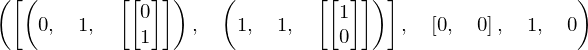

In [29]:
Eigen=[]
Trace=[]
Deter=[]
for Matrix in StStateMatrix:
    Eigen.append(Matrix.subs(ReplParamVal).eigenvects())
    Trace.append(Matrix.subs(ReplParamVal).trace())
    Deter.append(Matrix.subs(ReplParamVal).det())

Eigen[0], EqPoint[0], Trace[0], Deter[0]

Looking at the eigenvectors of the point $(0,0)$ we can see that they are both real, one is zero and the other is positive, $1$. Positive trace and zero determinant: it is an unstable fixed points.

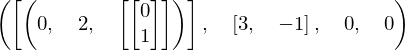

In [30]:
Eigen[1], EqPoint[1], Trace[1], Deter[1]

Looking at the eigenvectors of the point $(-\rho,-1)$ we can see that they are both zero. Zero trace and zero determinant: it is an line of fixed points.

We will now plot the solution.

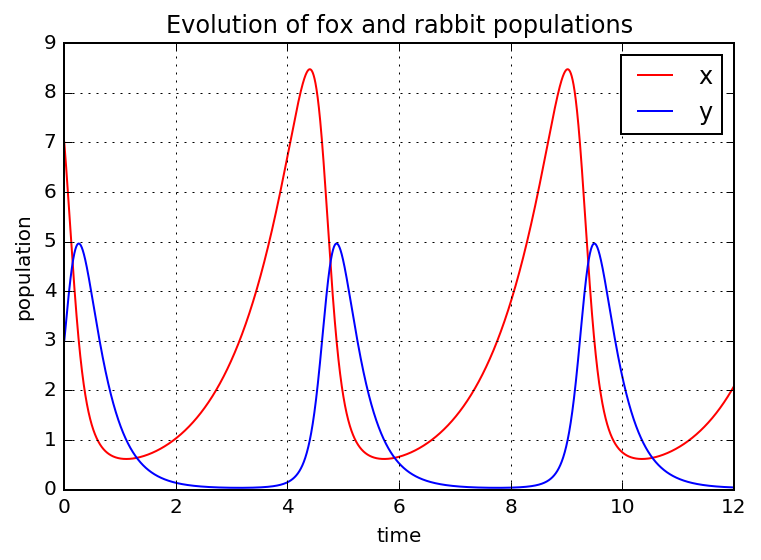

In [31]:
f1 = plt.figure()
plt.plot(t, sol_xy[:, 0], 'r-', label='x')
plt.plot(t, -sol_xy[:, 1]  , 'b-', label='y') # Note because of our nondimensionalization, we consider the opposite of the second component.
plt.grid()
plt.legend(loc='best')
plt.xlabel('time')
plt.ylabel('population')
plt.title('Evolution of fox and rabbit populations')
plt.show()
f1.savefig('OutImage/rabbits_and_foxes_NonDim_1.png')

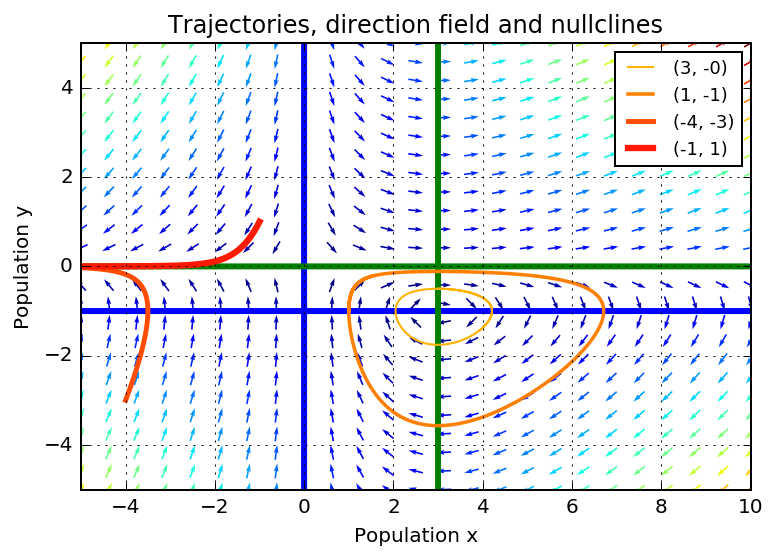

In [32]:
X_f1= np.array(EqPoint[1][:], dtype=np.float64)
X_fs= np.array(x_y_0 , dtype=np.float64) #x_y_0 EqPoint[1][:]

#StartPoints = np.array([[X_f1[0]-2,X_f1[1]+1], [X_fs[0]-1,X_fs[1]+1], [2,-1] , [-1,-5], [1,-2], [1,3]])  
#StartPoints = np.array([[3,-1],[2,-5], [-3,-5], [-2,7]]) 
StartPoints = np.array([[3,-0.5],[1,-1], [-4,-3], [-1,1] ])  #todo Look after: , [2,3]

values  = np.linspace(0.3, 0.9, len(StartPoints))  

t = np.linspace(0, 5, 10000)
f2 = plt.figure()
# plot trajectories
for point, v in zip(StartPoints, values): 
    X0 = point                     # starting point (internal)
    sol_X = odeint(lotka_voltera_rhs, np.transpose(X0), t, args=argsPar)
    plt.plot( sol_X[:,0], sol_X[:,1], lw=3.5*v, color=plt.cm.autumn_r(v), label='(%.f, %.f)' % ( X0[0], X0[1]) )

#-------------------------------------------------------
# define a grid and compute direction at each point
ymax = 5 #plt.ylim(ymin=0)[1]                      # get axis limits
xmax = 10 #plt.xlim(xmin=0)[1] 
ymin = -5
xmin = -5
nb_points   = 25                      

x = np.linspace(xmin, xmax, nb_points)
y = np.linspace(ymin, ymax, nb_points)

X1 , Y1  = np.meshgrid(x, y)                       # create a grid
DX1, DY1 = dX_dt_numeric(X1, Y1, argsPar[0])   # compute growth rate on the grid
M = (np.hypot(DX1, DY1))                           # Norm of the growth rate 
M[ M == 0] = 1.                                    # Avoid zero division errors 
DX1 /= M                                           # Normalize each arrows
DY1 /= M                                  
#-------------------------------------------------------
# Draw direction fields, using matplotlib 's quiver function
Q = plt.quiver(X1, Y1, DX1, DY1, M, pivot='mid', cmap=plt.cm.jet)


# Now find the nullclines.  Use matplotlib's contour routine to find the zero level.
# We will need a fine mesh, reevaluate DX1 and DY1 on the finer grid, and use contour 
# to find the level curves
x = np.linspace(xmin, xmax, nb_points*10)
y = np.linspace(ymin, ymax, nb_points*10)
X1 , Y1  = np.meshgrid(x, y)                    
dX1, dY1 = dX_dt_numeric(X1, Y1, argsPar[0]) 
plt.contour(X1, Y1, dX1, levels=[0], linewidths=3, colors='blue')
plt.contour(X1, Y1, dY1, levels=[0], linewidths=3, colors='green')


plt.title('Trajectories, direction field and nullclines')
plt.xlabel('Population x')
plt.ylabel('Population y')
plt.legend(loc='best', fontsize=9)
plt.grid()
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.show()
f2.savefig('OutImage/rabbits_and_foxes_NonDim_2.png')